# Trees

In [1]:
# Get data import sorted out
library(readr)
beer=read_csv("../data/data.csv")
# Remove erronious SG measurements
beer.normGrav = beer[beer$OG < 3,]
# Take a subsample for computational speed
beer.normGrav.subsample = beer.normGrav[sample(1:nrow(beer.normGrav), 1000),]

# Random seed for reproducibility
set.seed(1234)

Parsed with column specification:
cols(
  ID = col_integer(),
  Size = col_double(),
  OG = col_double(),
  FG = col_double(),
  IBU = col_double(),
  Color = col_double(),
  BoilSize = col_double(),
  BoilTime = col_integer(),
  BoilGravity = col_double(),
  Efficiency = col_double(),
  MashThickness = col_double(),
  ABV = col_double()
)


In [2]:
# The ensemble-based methods are somewhat expensive for a single thread, so let's parallelize a bit here
library(parallel)
ncores = detectCores() - 1
cluster = makeCluster(ncores)

## Single Regression Tree

In [3]:
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


We can use this random forest generator to get individual trees by restricting the number of trees in the "forest" to 1 and by removing the random choice in the random forest (having it look at all potential regressors instead of a random subset). Also, this particular module is optimized enough that we can just look at the full dataset without needing to resort to subsampling.


Call:
 randomForest(formula = ABV ~ ., data = beer.normGrav, ntree = 1,      mtry = 11, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 1
No. of variables tried at each split: 11

          Mean of squared residuals: 0.1957013
                    % Var explained: 94.14


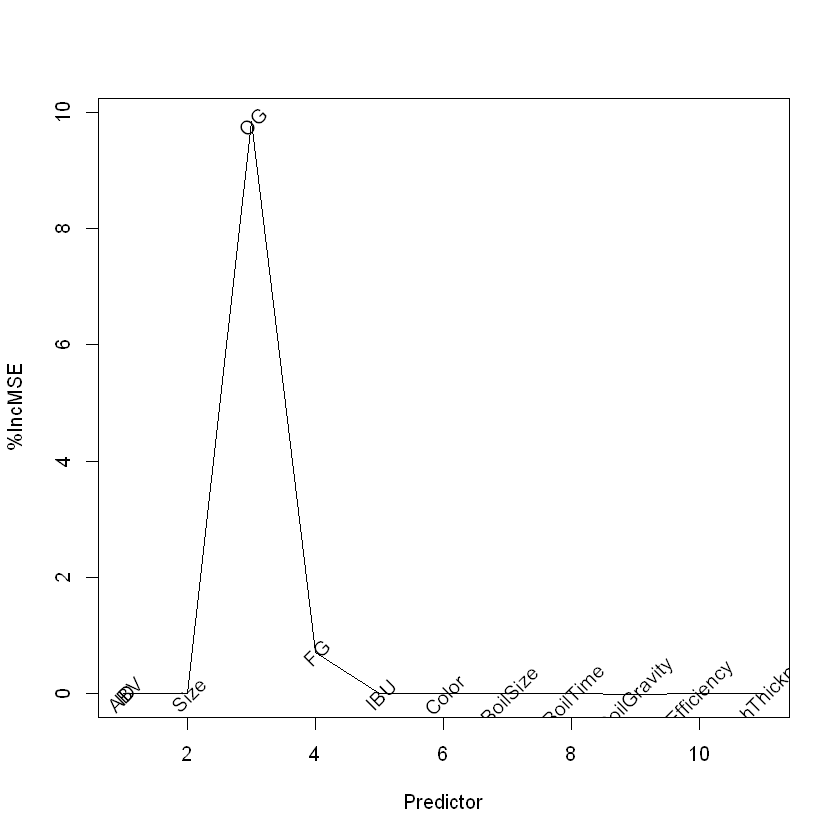

In [4]:
beer.normGrav.tree = randomForest(ABV~., data = beer.normGrav, ntree = 1, mtry = 11, importance = TRUE)
print(beer.normGrav.tree)
plot(beer.normGrav.tree$importance[,1], type="l", xlab="Predictor", ylab="%IncMSE")
text(beer.normGrav.tree$importance[,1], labels=colnames(beer.normGrav), srt=45, offset=1)


Call:
 randomForest(formula = ABV ~ ., data = beer.normGrav.subsample,      ntree = 1, mtry = 11, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 1
No. of variables tried at each split: 11

          Mean of squared residuals: 0.1376114
                    % Var explained: 97.3


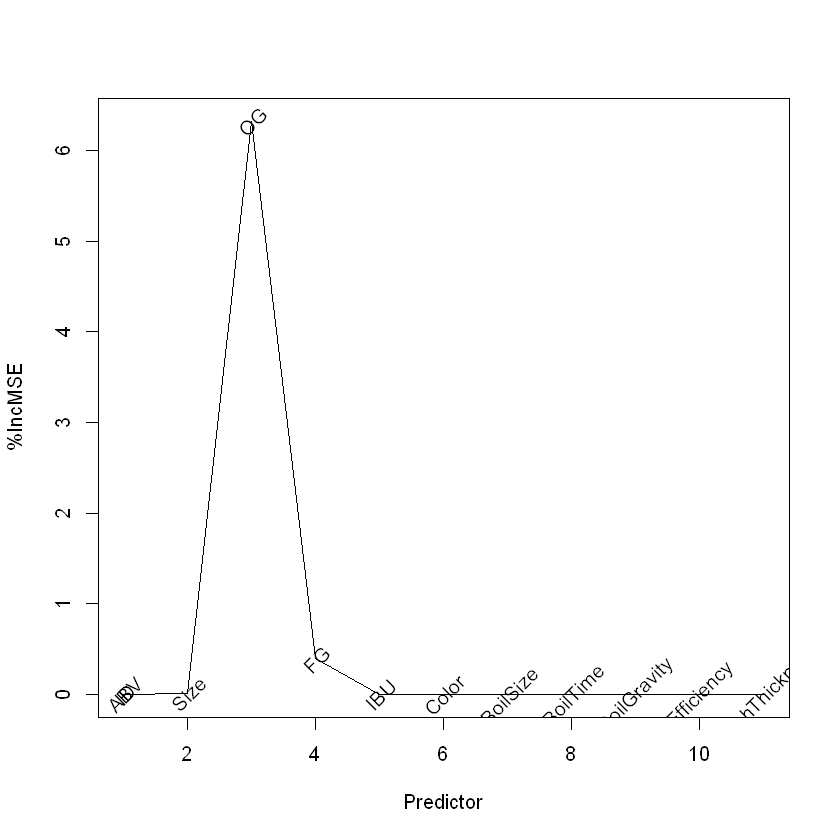

In [5]:
beer.normGrav.subsample.tree = randomForest(ABV~., data=beer.normGrav.subsample, ntree=1, mtry=11, importance=TRUE)
print(beer.normGrav.subsample.tree)
plot(beer.normGrav.subsample.tree$importance[,1], type="l", xlab="Predictor", ylab="%IncMSE")
text(beer.normGrav.subsample.tree$importance[,1], labels=colnames(beer.normGrav.subsample), srt=45, offset=1)

A single tree is going to have a pretty high bias. There are a few ways we can mitigate this before we go to a fully-fledged random forest. We can try boosting and bagging these trees.

## Bagged Regression Trees

In [6]:
# Let's check out the MSE as a function of the number of trees in our "Forest"
# For this, we'll definitely need to go to a subsample, and parallelize a bit

beer.normGrav.subsample.bagged.funct = function(nTrees){
    result = mean(replicate(nTrees, randomForest(ABV~., data=beer.normGrav.subsample, ntree=1, mtry=11, importance=FALSE)$mse))
    return(result)
}
beer.normGrav.subsample.bagged.x = seq(from=1, to=500, by=1)
clusterExport(cl=cluster, varlist=c("beer.normGrav.subsample",
                                    "beer.normGrav.subsample.bagged.x",
                                    "randomForest")
             )
# This took about 15 minutes to run, so I'm going to comment this out just in case I accidentally re-run this cell
beer.normGrav.subsample.bagged.y = parLapply(cluster, beer.normGrav.subsample.bagged.x, beer.normGrav.subsample.bagged.funct)

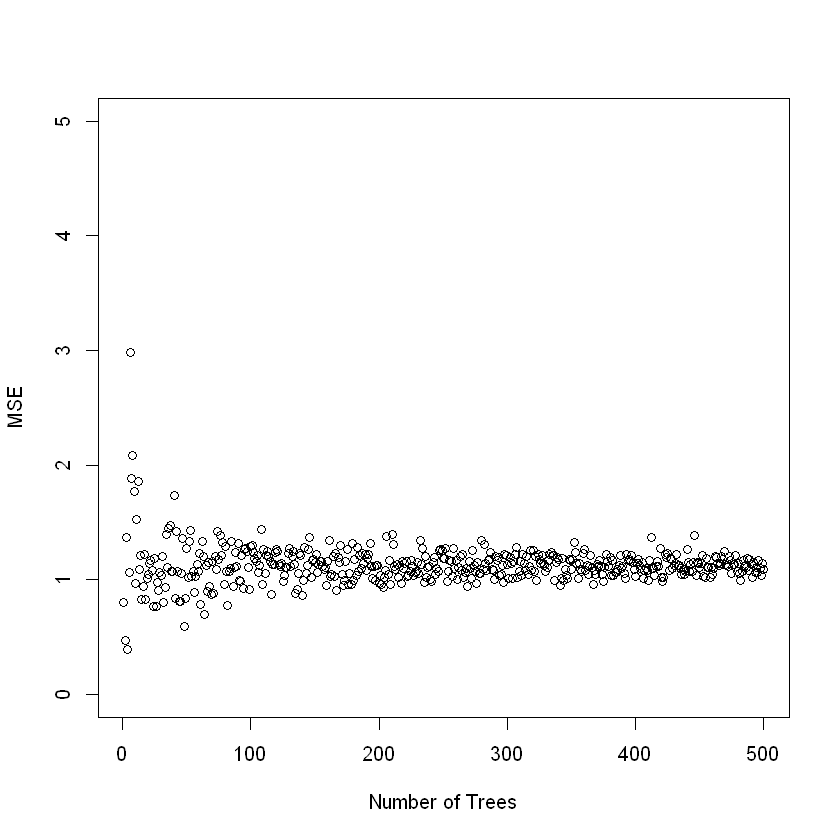

In [12]:
plot(x=beer.normGrav.subsample.bagged.x, y=beer.normGrav.subsample.bagged.y, xlab="Number of Trees", ylab="MSE", ylim=c(0,5))

After around 200 trees, we don't really gain much in the way of MSE  by increasing the size of our bagged forest. Let's see how well the random forest performs in comparison.

## Random Forest

In [8]:
beer.normGrav.subsample.randForest.funct = function(nTrees){
    result = mean(randomForest(ABV~., data=beer.normGrav.subsample, ntree=nTrees, importance=FALSE)$mse)
    return(result)
}
beer.normGrav.subsample.randForest.x = seq(from=1, to=500, by=1)
beer.normGrav.subsample.randForest.y = parLapply(cluster, beer.normGrav.subsample.randForest.x, beer.normGrav.subsample.randForest.funct)

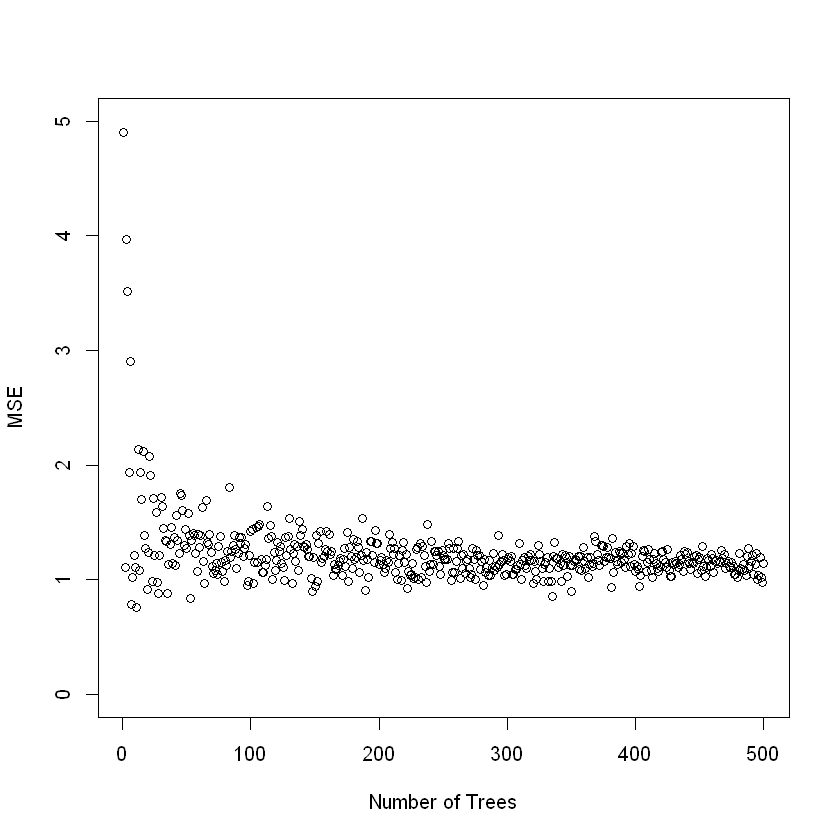

In [13]:
plot(x=beer.normGrav.subsample.randForest.x, y=beer.normGrav.subsample.randForest.y, xlab="Number of Trees", ylab="MSE", ylim=c(0,5))

We converge to a similar MSE, but because we have so much data, I'm more willing to trust the random forest's result over the bagged trees. Let's take a look at the "variable importance" metric of the random forest once again with a forest containing 200 trees.


Call:
 randomForest(formula = ABV ~ ., data = beer.normGrav.subsample,      ntree = 200, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 200
No. of variables tried at each split: 3

          Mean of squared residuals: 1.018383
                    % Var explained: 80.04


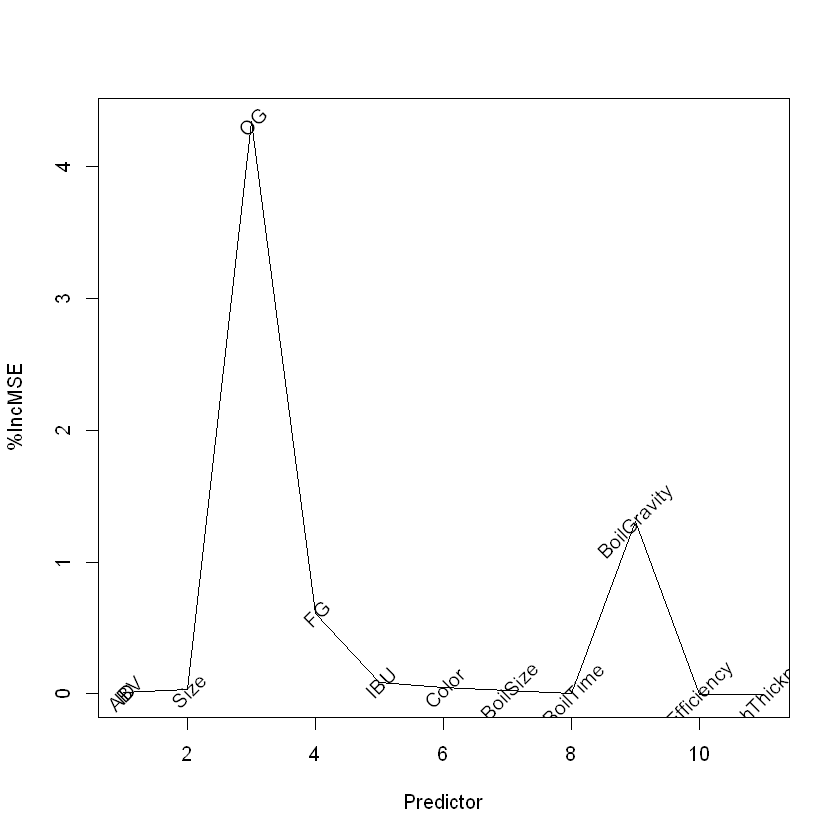

In [10]:
beer.normGrav.subsample.randForest.tree200 = randomForest(ABV~., data=beer.normGrav.subsample, ntree=200, importance=TRUE)
print(beer.normGrav.subsample.randForest.tree200)
plot(beer.normGrav.subsample.randForest.tree200$importance[,1], type="l", xlab="Predictor", ylab="%IncMSE")
text(beer.normGrav.subsample.randForest.tree200$importance[,1], labels=colnames(beer.normGrav.subsample), srt=45, offset=1)

Interestingly, the random forest picks out yet another descriptor relating to the sugar content: the specific gravity of the wort during the boil. And it picks it more often than the final specific gravity.